# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [11]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from time import time
from sklearn.inspection import permutation_importance
from scipy import stats
import math
import datashader as ds
from datashader.mpl_ext import dsshow

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import multiprocessing

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
def using_datashader(ax, x, y, normalisation):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(df,ds.Point("x", "y"),ds.count(), vmin=0.1, vmax=100,norm=normalisation,aspect="auto",ax=ax)
    plt.colorbar(dsartist, ax=ax)
    
def run_model_with_cv(model,model_name, metrics, cv, X_train, Y_train, regex_name, regex_pattern):
    print("Running {} model, variables include {}".format(model_name,  regex_name))

    # Filter columns using the regex pattern in function input
    X_train = X_train[X_train.columns.drop(list(X_train.filter(regex=regex_pattern)))].copy()
    
    # Get list of all features
    feature_list = list(X_train.columns)
        
    # Perform cross validation, time how long it takes
    start = time()
    model_output = cross_validate(model, X_train, Y_train, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
    end = time()
    
    #  Create a dataframe containng scores for each performance metric
    df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
         'r2': round(abs(model_output['test_r2'].mean()),2), 'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                     index =["{}_{}".format(model_name, regex_name)])
    
    # Get the estimators 
    estimators = model_output['estimator']
    
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    return [estimators, df, feature_list]    

### Read in formatted data

In [145]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Keep only sensors with relatively complete data

In [125]:
# data = data.drop(['Pressure', 'Humidity'],axis=1) # seem obviously irrelevant
# data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

### Add a random variable (to compare performance of other variables against)

In [126]:
data['random'] = np.random.random(size=len(data))

In [16]:
# plt.scatter(data['Cos_time'],data['Sin_time'])#.set_aspect('equal')

## Prepare data for modelling 
### Split into predictor/predictand variables

In [127]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

In [146]:
data['sensor_id'].unique()

array([ 9,  8, 18,  2, 10, 11,  6])

### Split into training and test data

In [128]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.75, random_state=123)

In [129]:
data_time_columns_train = X_train[["sensor_id",'day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num']]
data_time_columns_test = X_test[["sensor_id",'day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num']]
X_train = X_train.drop(["sensor_id",'day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)
X_test = X_test.drop(["sensor_id",'day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

### Standardize both training and testing data

In [10]:
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Define models (linear regression, random forest and XGBoost)

In [130]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 60)
xgb_model = XGBRegressor(random_state=1, n_jobs = 200)
et_model =ExtraTreesRegressor (n_estimators = 50, random_state = 1, n_jobs = 60)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [131]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [132]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$',
                     'nosubtyes':'buildings_|furniture_|landmarks_|sensor_id'}
#                      'time_and_weather':'buildings|furniture|landmarks|h_|lights|avg_n_floors|betweenness',
#                       'just_location_features':'buildings$|furniture$|landmarks$|school_holiday|public_holiday|Temp|Humidity|Pressure|Rain|WindSpeed|Sin|Cos'}

### Loop through each combination of the models, and the variables to include in the modelling

In [134]:
# # Dataframe to store the scores for each model
# error_metric_scores = pd.DataFrame()

# # Dictionary to store dataframes of feature importance scores
# feature_importance_scores ={}

# models_dict = {"xgboost":xgb_model}
# for model_name,model in models_dict.items():
#     for regex_name, regex in column_regex_dict.items():
#         # Run the model: return the estimators and a dataframe containing evaluation metrics
#         estimators, error_metrics_df, feature_list = run_model_with_cv(
#             model, model_name, error_metrics, cv_parameters, X_train, Y_train, regex_name, regex) 
#         # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
#         error_metric_scores = error_metric_scores.append(error_metrics_df)
        
#         # Create dataframe of feature importances (no feature importances for linear regression)
#         if model_name != 'linear_regression':
#             feature_importances = pd.DataFrame(index =[feature_list])
#             for idx,estimator in enumerate(estimators):
#                     feature_importances['Estimator{}'.format(idx)] = estimators[idx].feature_importances_
#             feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

In [44]:
error_metrics_df

,mae,r2,rmse
xgboost_nosubtyes,101.04,0.82,186.65


In [28]:
for idx,estimator in enumerate(estimators):
    # Get the model and fit it to ?? 
    model = estimators[idx].fit(X_train, Y_train)
    predictions = model.predict(X_test)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=200, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, reg_lambda=1, ...)

### Feature importances?

In [17]:
# feature_importance_scores["xgboost_withsubtypes"].sort_values('Estimator0', ascending = False)[0:10]

## Choose the best model 

Random Forest was the best performing model

## Fit the final model
For this, we use all of the training data

In [40]:
# xgb_1_model = estimators[0].fit(X_train, Y_train)
# xgb_1_predictions = xgb_1_model.predict(X_test)
# xgb_1_predictions

array([-28.278595 , 169.78279  ,   7.6221447, ...,  73.09885  ,
       126.34224  , 224.36252  ], dtype=float32)

In [135]:
# fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))
# using_datashader(axs[2], Y_test, xgb_1_predictions, 'log')
# axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
# axs[2].set_ylabel("Predicted Values", size=10)
# axs[2].set_xlabel("Actual Values", size=10)
# axs[2].xaxis.set_tick_params(labelsize='xx-large')
# axs[2].yaxis.set_tick_params(labelsize='xx-large')
# axs[2].set_xlim([0, 2000])
# axs[2].set_ylim([0, 2000])

In [136]:
rf_final_model = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 64)
rf_final_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=500, n_jobs=64, random_state=1)

### Use this model to make predictions

In [137]:
rf_predictions = rf_final_model.predict(X_test)

### Find the absoloute error in each prediction

In [102]:
data_time_columns_test

,day_of_month_num,time,weekday_num,time_of_day,year,month,day,datetime,month_num
589842,28,23,5,evening,2021,May,Friday,2021-05-28 23:00:00,5
34199,10,19,3,evening,2011,August,Wednesday,2011-08-10 19:00:00,8
226081,9,5,2,nighttime,2014,December,Tuesday,2014-12-09 05:00:00,12
244804,10,5,5,nighttime,2015,April,Friday,2015-04-10 05:00:00,4
311966,20,12,1,morning,2016,June,Monday,2016-06-20 12:00:00,6
...,...,...,...,...,...,...,...,...,...
422982,27,23,3,evening,2018,June,Wednesday,2018-06-27 23:00:00,6
392949,12,10,2,morning,2017,December,Tuesday,2017-12-12 10:00:00,12
657169,20,8,3,morning rush hour,2022,July,Wednesday,2022-07-20 08:00:00,7
579351,20,20,6,evening,2021,March,Saturday,2021-03-20 20:00:00,3


In [53]:
final_model_predictions_df = pd.DataFrame({'Predictions' :rf_predictions, 'Original':Y_test,
                          'abs_errors': abs(rf_predictions - Y_test),'Hour':data_time_columns_test['time']})

In [82]:
# Calculate the absolute errors
abs_errors = abs(rf_predictions - Y_test)
# Mean absolute percentage errors
mape = mean_absolute_percentage_error(Y_test, rf_predictions)
# Mean absolute error
mae = round(np.mean(abs_errors), 2)
# Calculate r2 value (well, just_rvalue, its squared in the print statement)
m, b, r_value, p_value, std_err = stats.linregress(rf_predictions, Y_test)
# RMSE
MSE = np.square(np.subtract(rf_predictions,Y_test)).mean() 
RMSE = math.sqrt(MSE)

# Add to Dataframe
accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['RandomForest_allhours'])
accuracy_results_rf

,MAPE,MAE,RMSE,R2
RandomForest_allhours,1.263673e+15,77.92,157.962725,0.867202


### Find the error for each hour of the day

In [91]:
all_hours_accuracy = pd.DataFrame()

for hour in list(range(0,24)):
    this_hour = final_model_predictions_df[final_model_predictions_df['Hour']==hour]

    # Mean absolute percentage errors
    mape = mean_absolute_percentage_error(this_hour['Original'], this_hour['Predictions'])
    # Mean absolute error
    mae = round(np.mean(this_hour['abs_errors']), 2)
    # Calculate r2 value (well, just_rvalue, its squared in the print statement)
    m, b, r_value, p_value, std_err = stats.linregress(this_hour['Predictions'], this_hour['Original'])
    # RMSE
    MSE = np.square(np.subtract(this_hour['Predictions'], this_hour['Original'])).mean() 
    RMSE = math.sqrt(MSE)
    
    # Add to Dataframe
    accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =[hour])

    all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)
        
# all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)

In [92]:
# all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)
all_hours_accuracy

,MAPE,MAE,RMSE,R2
0,1.315488e+15,27.03,73.469370,0.772437
1,2.180495e+15,17.69,48.540105,0.697339
2,2.413551e+15,11.66,40.738953,0.597523
3,2.028387e+15,10.22,41.138708,0.468704
4,1.727831e+15,8.57,28.543862,0.440707
5,6.648517e+14,14.80,30.002095,0.698078
6,6.370409e+14,51.09,101.806260,0.768848
7,1.084538e+15,109.01,213.095062,0.798787
8,1.977707e+15,125.85,229.133739,0.789522
9,7.688118e+14,114.88,194.776416,0.821505


### Find the error for each sensor

In [140]:
all_sensors_accuracy

,MAPE,MAE,RMSE,R2
8,1.031296e+15,41.92,72.229259,0.795951
10,2.104383e+15,64.17,113.860998,0.600308
11,1.172914e+15,35.05,79.678365,0.587888
2,5.639634e+14,87.87,168.453125,0.900813
9,6.037793e+14,86.64,184.895571,0.831513
6,2.810940e+15,197.45,285.756354,0.775990
18,4.876807e+14,52.90,126.110607,0.904378


In [138]:
final_model_predictions_df = pd.DataFrame({'Predictions' :rf_predictions, 'Original':Y_test,
                          'abs_errors': abs(rf_predictions - Y_test),'SensorID':data_time_columns_test['sensor_id']})

final_model_predictions_df
all_sensors_accuracy = pd.DataFrame()

for sensor_id in final_model_predictions_df['SensorID'].unique():
    this_sensor = final_model_predictions_df[final_model_predictions_df['SensorID']==sensor_id]

    # Mean absolute percentage errors
    mape = mean_absolute_percentage_error(this_sensor['Original'], this_sensor['Predictions'])
    # Mean absolute error
    mae = round(np.mean(this_sensor['abs_errors']), 2)
    # Calculate r2 value (well, just_rvalue, its squared in the print statement)
    m, b, r_value, p_value, std_err = stats.linregress(this_sensor['Predictions'], this_sensor['Original'])
    # RMSE
    MSE = np.square(np.subtract(this_sensor['Predictions'], this_sensor['Original'])).mean() 
    RMSE = math.sqrt(MSE)
    
    # Add to Dataframe
    accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =[sensor_id])

    all_sensors_accuracy = all_sensors_accuracy.append(accuracy_results_rf)
        
# all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)

### Check error variation at time of day

In [93]:
sensor_data = pd.read_csv("../Cleaned_data/single_sensor_locations.csv")
sensor_data = sensor_data.groupby('hour')['hourly_counts'].mean()

In [94]:
all_hours_accuracy['avg_value'] = sensor_data
all_hours_accuracy['relative_error'] = (all_hours_accuracy['MAE']/all_hours_accuracy['avg_value'])*100

<BarContainer object of 24 artists>

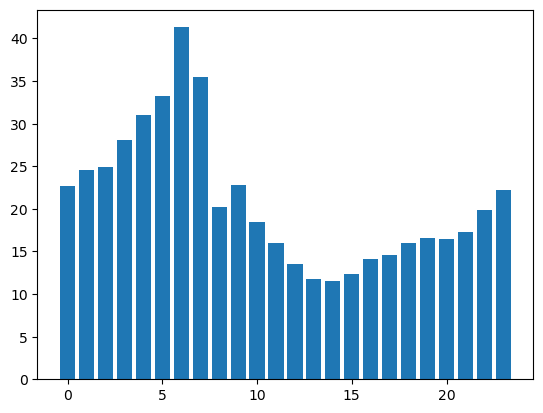

In [97]:
# plt.bar(list(range(0,24)), all_hours_accuracy['relative_error'][:-1])
plt.bar(list(range(0,24)), all_hours_accuracy['relative_error'])

### Find Gini impurity feature importances

In [16]:
# Get numerical feature importances
rf_importances = list(rf_final_model.feature_importances_)
rf_feature_importances = pd.DataFrame({'feature': X_test.columns,'importance':rf_importances})      
rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = True)
# rf_feature_importances = rf_feature_importances[0:10]

rf_feature_importances_overrandom = rf_feature_importances[rf_feature_importances['importance']>rf_feature_importances.query("feature=='random'")["importance"].values[0]]

### Find the permutation importance

In [288]:
# Using form eli5.sklearn import PermutationImportance
#instantiate permuter object
permuter = PermutationImportance(rf_final_model, scoring='neg_mean_absolute_error', cv='prefit', n_iter=2, random_state=42)
permuter.fit(X_train, Y_train)
eli5_permutation_fi = pd.DataFrame({'Feature_name':X_train.columns,
              'Feature_importance':permuter.feature_importances_,
              'Feature_importance_std': permuter.feature_importances_std_}).sort_values('Feature_importance', ascending = True)

eli5_permutation_fi_overrandom = eli5_permutation_fi[eli5_permutation_fi['Feature_importance']>eli5_permutation_fi.query("Feature_name=='random'")["Feature_importance"].values[0]]

### Plot and compare feature importances

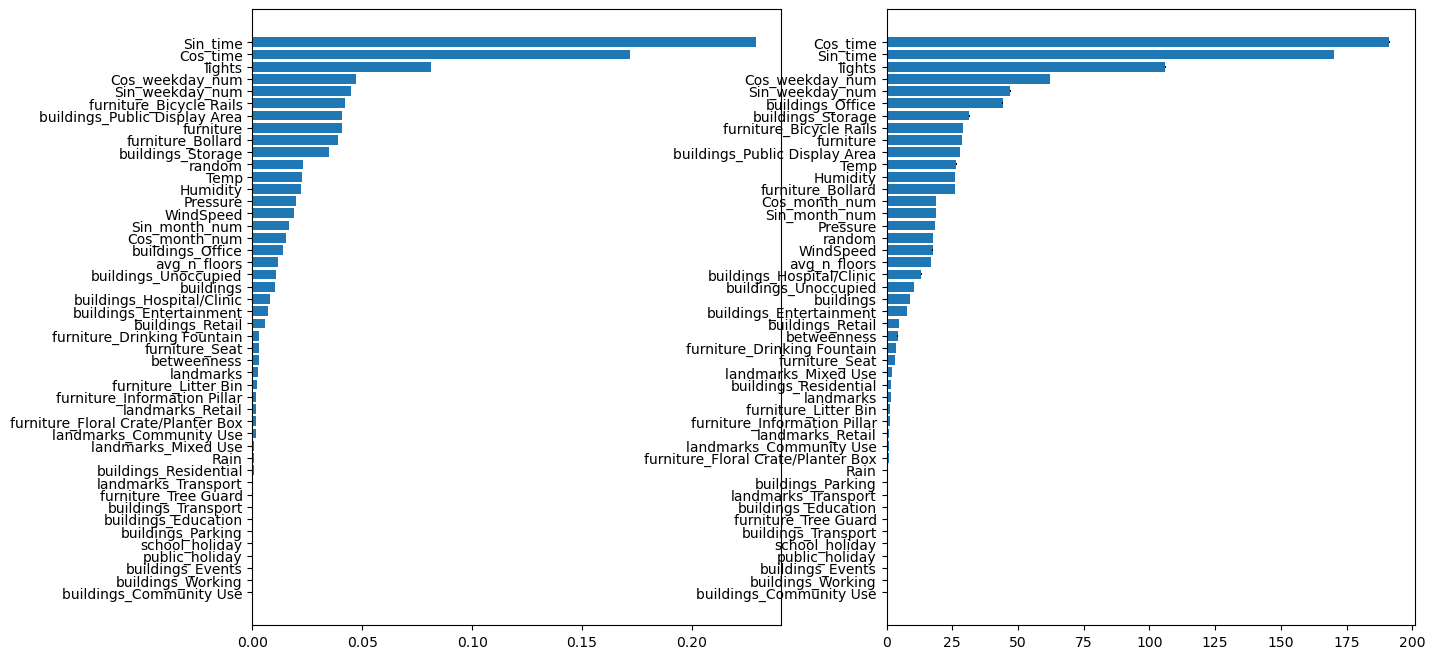

In [285]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
axs[0].barh(range(len(rf_feature_importances['importance'])), rf_feature_importances["importance"])
axs[0].set_yticks(range(len(rf_feature_importances["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances["feature"]))

axs[1].barh(range(len(eli5_permutation_fi['Feature_importance'])),
         eli5_permutation_fi['Feature_importance'],
         xerr=eli5_permutation_fi['Feature_importance_std'])
axs[1].set_yticks(range(len(eli5_permutation_fi['Feature_importance'])))
_ = axs[1].set_yticklabels(eli5_permutation_fi['Feature_name'])   

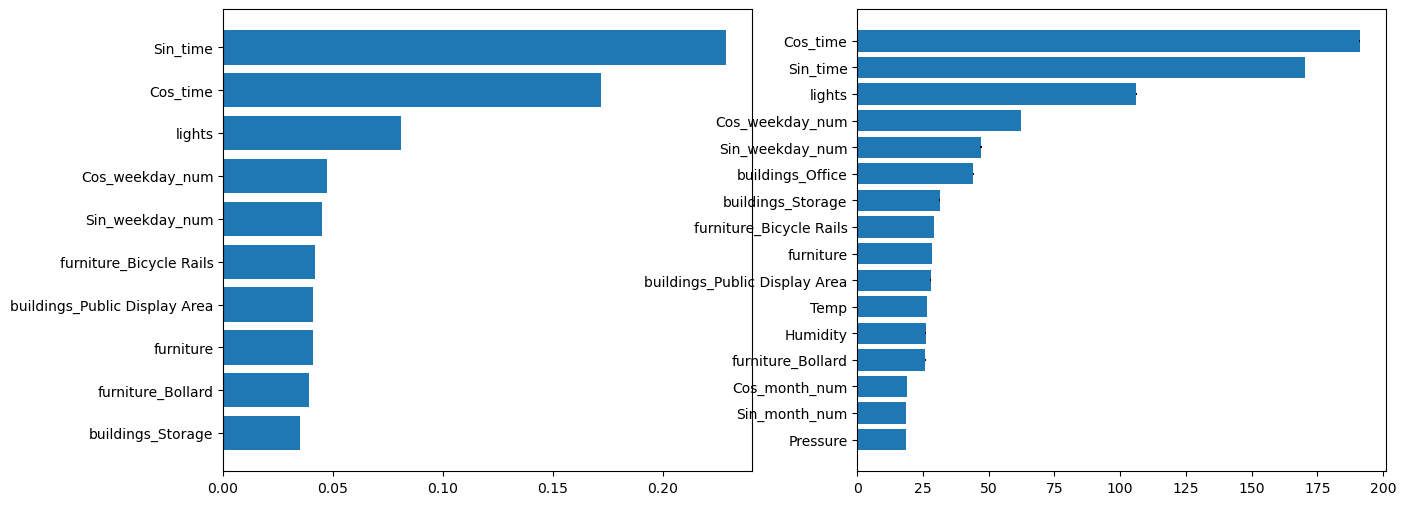

In [289]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,6))
axs[0].barh(range(len(rf_feature_importances_overrandom['importance'])), rf_feature_importances_overrandom["importance"])
axs[0].set_yticks(range(len(rf_feature_importances_overrandom["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances_overrandom["feature"]))

axs[1].barh(range(len(eli5_permutation_fi_overrandom['Feature_importance'])),
         eli5_permutation_fi_overrandom['Feature_importance'],
         xerr=eli5_permutation_fi_overrandom['Feature_importance_std'])
axs[1].set_yticks(range(len(eli5_permutation_fi_overrandom['Feature_importance'])))
_ = axs[1].set_yticklabels(eli5_permutation_fi_overrandom['Feature_name'])   

### Plots!?

In [1]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[1],Y_test, rf_predictions, 'linear')
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], Y_test, rf_predictions, 'log')
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_ylabel("Predicted Values", size=10)
axs[2].set_xlabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

NameError: name 'plt' is not defined